# Import dependencies and determine working directory

In [27]:
# Import libraries
from os import path
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
import time
import cv2

In [2]:
# Importing the Keras libraries and packages
# import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# Load training data

In [3]:
# Load data from pickled file 
filename_in__images_train = path.join('..', '04_processed_data','mini_images_train.pkl')
filename_in__emotions_train = path.join('..', '04_processed_data','mini_emotions_train.pkl')

X_train = joblib.load(filename_in__images_train)
y_train = joblib.load(filename_in__emotions_train)

In [4]:
filename_in__images_test = path.join('..', '04_processed_data','mini_images_test.pkl')
filename_in__emotions_test = path.join('..', '04_processed_data','mini_emotions_test.pkl')

X_test = joblib.load(filename_in__images_test)
y_test = joblib.load(filename_in__emotions_test)

# Build a CNN model

In [5]:
def reshape_image(array_in):
    image_side = int(array_in.shape[1]**0.5)
    array_2d = []
    for row in array_in: 
        array_2d.append(np.reshape(row, (image_side, image_side, 1) ) )
    array_2d = np.array(array_2d)
    return array_2d

In [6]:
# reshape data
X_train = reshape_image(X_train)
X_test = reshape_image(X_test)

In [7]:
# get parameters for input data 
input_shape = (X_train.shape[1] , X_train.shape[2], X_train.shape[3])
num_classes = len(set(y_train))

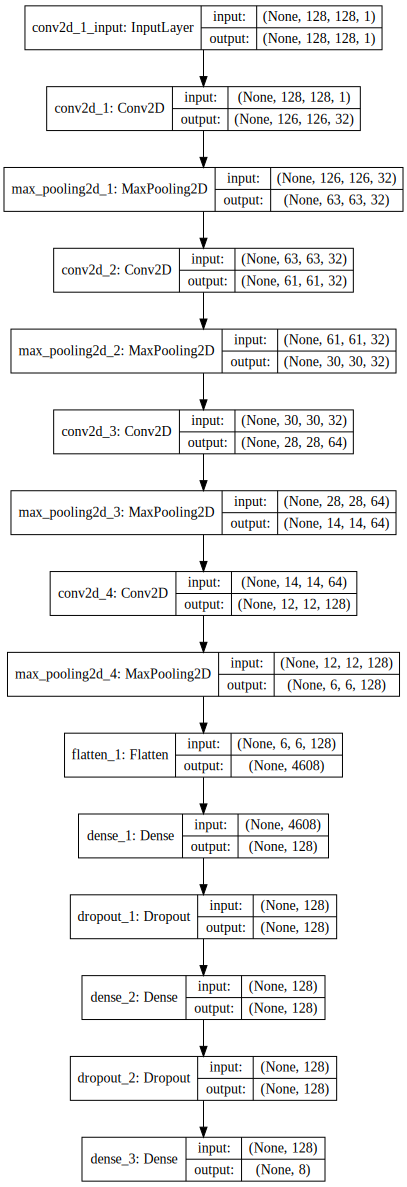

In [8]:
def construct_architecture_1(input_shape, num_classes):
    # instantiate model
    dnn_model = Sequential()
    # add convolution and pooling layers
    dnn_model.add( Conv2D(32, kernel_size=(3, 3), input_shape = input_shape, activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
    
    dnn_model.add( Conv2D(32, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
              
    dnn_model.add( Conv2D(64, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
              
    dnn_model.add( Conv2D(128, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
    
    dnn_model.add( Flatten() )
    
    # add dense layers
    dnn_model.add( Dense(128, activation ='elu') )
    dnn_model.add( Dropout(0.4) )
    dnn_model.add( Dense(128, activation ='elu') )
    dnn_model.add( Dropout(0.4) )
    # define output layer
    dnn_model.add( Dense(num_classes, activation='softmax') )
    # compile model
    dnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return dnn_model

# Create model instance
classifier_01 = construct_architecture_1(input_shape, num_classes)

# Vizualize network achitecture
SVG(model_to_dot(classifier_01, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

# Run model

In [10]:
def save_files(classifier, history, filename):
    
    print(history.history)
    # create filepaths
    classifier_name = filename + '_mini_model.h5'
    filename_out__classifier = path.join('..', '04_processed_data', classifier_name)
    # save model
    classifier.save(filename_out__classifier)

    print('Model saved')

In [11]:
# create a function that fits to training data
def run_model(classifier, filename):
    startTime = time.clock()
    
    # Define callbacks
    early_stopping_monitor = EarlyStopping(monitor='val_acc', patience=10)
    callbacks = [early_stopping_monitor]
    
    # Fit classifier
    history = classifier.fit(X_train, pd.get_dummies(y_train), epochs=20, 
                            batch_size = 128, validation_split=0.1, callbacks=callbacks)
    endTime = time.clock()
    print("Model is trained in {0} seconds!".format(endTime - startTime))
    
    # Saving the trained model
    print("Saving model...")
    save_files(classifier, history, filename)
    
    return classifier

In [12]:
classifier_01 = run_model(classifier_01, 'classifier_01')

Train on 1323 samples, validate on 147 samples
Epoch 1/20
1323/1323 [==============================] - 62s 47ms/step - loss: 11.1995 - acc: 0.1769 - val_loss: 3.3391 - val_acc: 0.1361
Epoch 2/20
1323/1323 [==============================] - 58s 44ms/step - loss: 3.1122 - acc: 0.1807 - val_loss: 2.1514 - val_acc: 0.2925
Epoch 3/20
1323/1323 [==============================] - 58s 44ms/step - loss: 2.2848 - acc: 0.2623 - val_loss: 2.0059 - val_acc: 0.2925
Epoch 4/20
1323/1323 [==============================] - 57s 43ms/step - loss: 1.6971 - acc: 0.4399 - val_loss: 1.5298 - val_acc: 0.4626
Epoch 5/20
1323/1323 [==============================] - 58s 44ms/step - loss: 1.4194 - acc: 0.5246 - val_loss: 1.6592 - val_acc: 0.4354
Epoch 6/20
1323/1323 [==============================] - 58s 44ms/step - loss: 1.0840 - acc: 0.6213 - val_loss: 1.3741 - val_acc: 0.5034
Epoch 7/20
1323/1323 [==============================] - 57s 43ms/step - loss: 0.8747 - acc: 0.6931 - val_loss: 0.9906 - val_acc: 0.6599


## Evaluate model performance

In [13]:
# Predict the labels
test_prediction_1 = classifier_01.predict_classes(X_test)

In [14]:
# Create labels
labels = [0,1,2,3,4,5,6,7]

In [15]:
test_cm_1 = metrics.confusion_matrix(y_test, test_prediction_1, labels=labels)
print('For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.')
print('Classifier 1:')
print(test_cm_1)
print('')
print('Classifier 1:')
test_score_1 = metrics.accuracy_score(y_test, test_prediction_1)
print("Accuracy: {:.3}".format(test_score_1))
test_precision_1 = metrics.precision_score(y_test, test_prediction_1, average = 'weighted')
print("Precision: {:.3}".format(test_precision_1))
test_recall_1 = metrics.recall_score(y_test, test_prediction_1, average = 'weighted')
print("Recall: {:.3}".format(test_recall_1))
print('')

# Compute precision and recall for classes in classifier 1
precision, recall, fscore, support = score(y_test, test_prediction_1)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

For the confusion matrix, rows correspond to actual ratings and the columns correspond to predicted ratings.
Classifier 1:
[[30  1  0  1  1  0  0  1]
 [ 3 15  0  1  0  0  1  0]
 [ 6  2  0  0  0  0  0  0]
 [ 4  0  0 19  0  0  0  0]
 [ 0  0  0  0  0  0  6  6]
 [ 0  3  0  0  1 24  0  0]
 [ 4  0  0  0  3  0  9  0]
 [ 0  0  0  0  0  0  0 24]]

Classifier 1:
Accuracy: 0.733
Precision: 0.681
Recall: 0.733

precision: [ 0.63829787  0.71428571  0.          0.9047619   0.          1.          0.5625
  0.77419355]
recall: [ 0.88235294  0.75        0.          0.82608696  0.          0.85714286
  0.5625      1.        ]


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
incorrect_filter = y_test != test_prediction_1

In [51]:
emotion_key = ['neutral', 'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise' ]
X_test_incorrect = X_test[incorrect_filter]
y_test_incorrect = list(y_test[incorrect_filter])
pred_incorrect = list(test_prediction_1[incorrect_filter])
length = len(X_test_incorrect)

Predicted:  disgust
Actual:  neutral


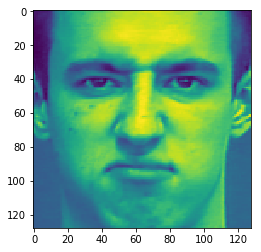

Predicted:  fear
Actual:  happiness


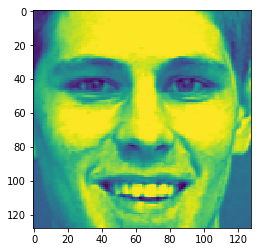

Predicted:  anger
Actual:  happiness


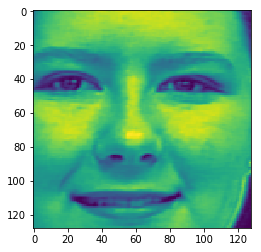

Predicted:  anger
Actual:  happiness


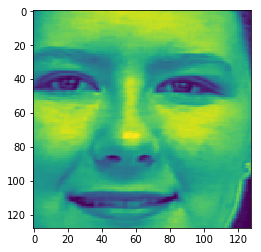

Predicted:  anger
Actual:  happiness


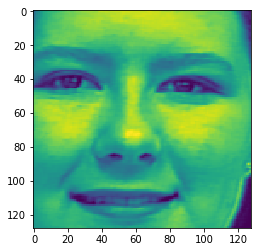

Predicted:  neutral
Actual:  contempt


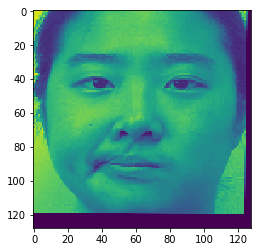

Predicted:  neutral
Actual:  contempt


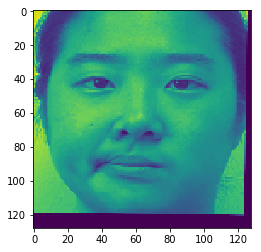

Predicted:  neutral
Actual:  contempt


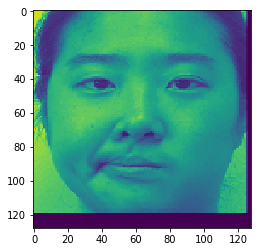

Predicted:  neutral
Actual:  contempt


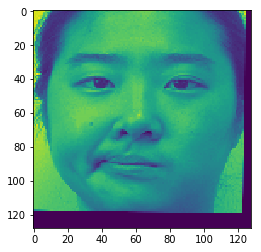

Predicted:  neutral
Actual:  anger


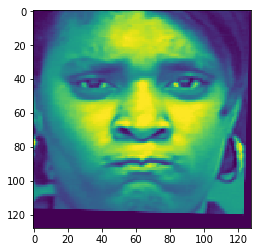

Predicted:  neutral
Actual:  anger


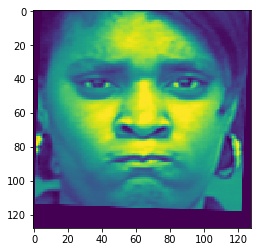

Predicted:  neutral
Actual:  anger


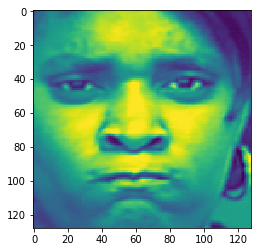

Predicted:  sadness
Actual:  anger


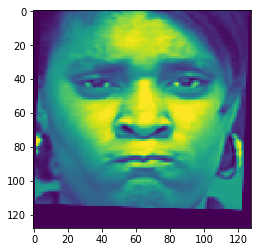

Predicted:  sadness
Actual:  fear


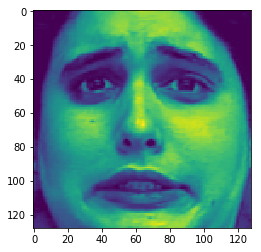

Predicted:  sadness
Actual:  fear


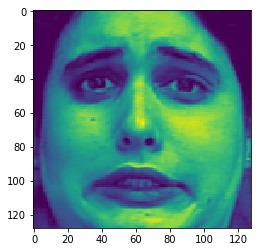

Predicted:  surprise
Actual:  fear


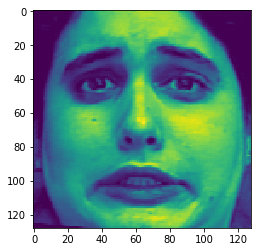

Predicted:  surprise
Actual:  fear


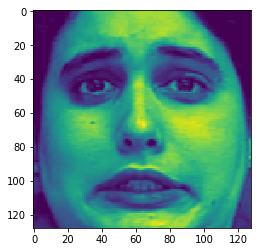

Predicted:  neutral
Actual:  sadness


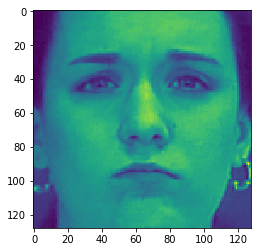

Predicted:  neutral
Actual:  sadness


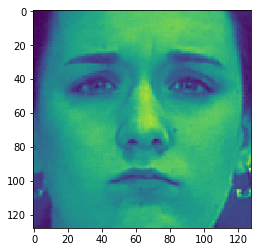

Predicted:  neutral
Actual:  sadness


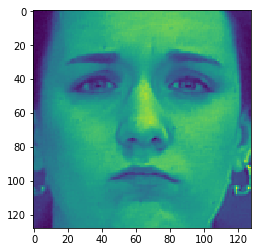

Predicted:  neutral
Actual:  sadness


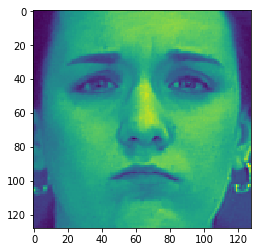

Predicted:  neutral
Actual:  disgust


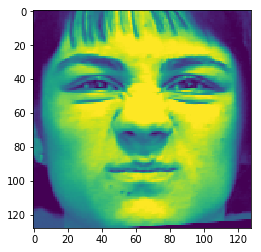

Predicted:  neutral
Actual:  disgust


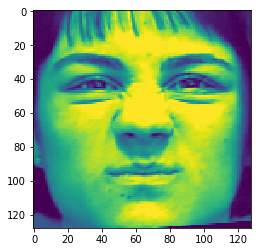

Predicted:  neutral
Actual:  disgust


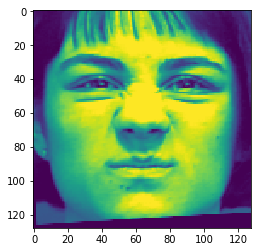

Predicted:  neutral
Actual:  disgust


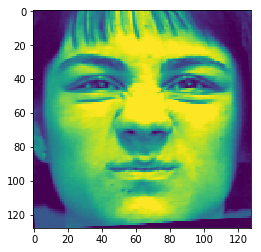

Predicted:  sadness
Actual:  fear


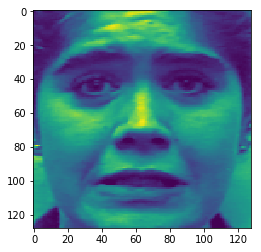

Predicted:  sadness
Actual:  fear


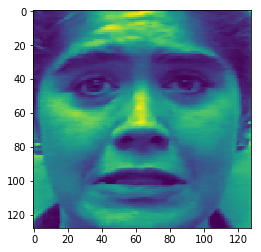

Predicted:  sadness
Actual:  fear


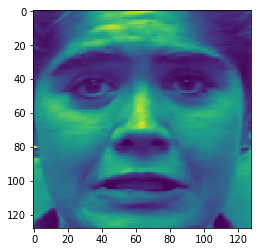

Predicted:  sadness
Actual:  fear


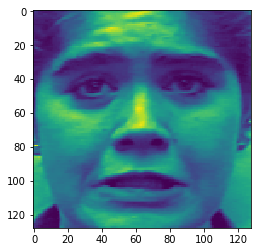

Predicted:  surprise
Actual:  fear


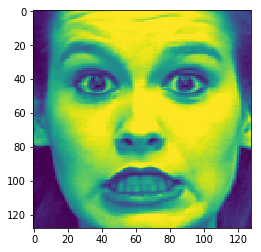

Predicted:  surprise
Actual:  fear


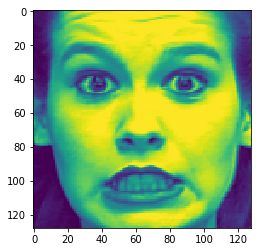

Predicted:  surprise
Actual:  fear


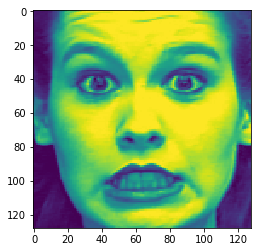

Predicted:  surprise
Actual:  fear


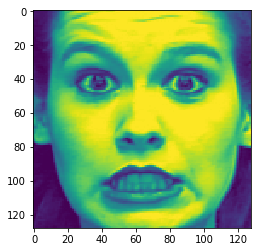

Predicted:  disgust
Actual:  anger


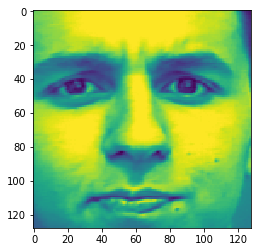

Predicted:  neutral
Actual:  contempt


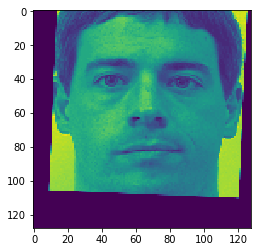

Predicted:  anger
Actual:  contempt


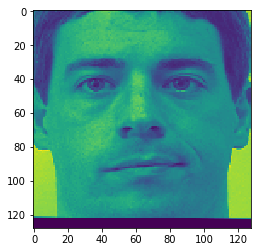

Predicted:  anger
Actual:  neutral


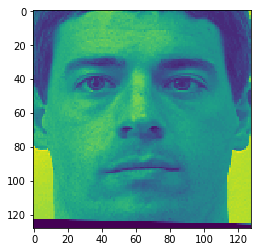

Predicted:  anger
Actual:  contempt


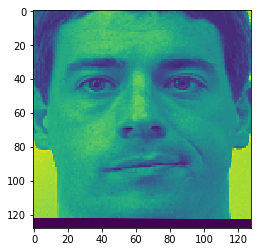

Predicted:  neutral
Actual:  contempt


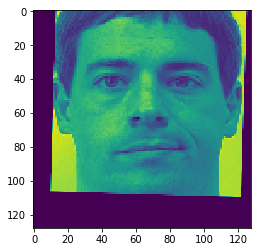

Predicted:  surprise
Actual:  neutral


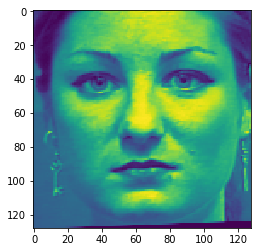

Predicted:  fear
Actual:  sadness


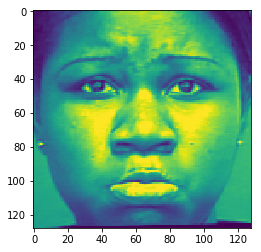

Predicted:  fear
Actual:  sadness


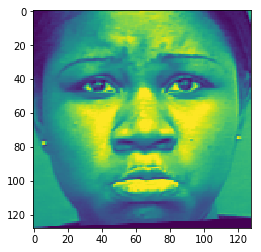

Predicted:  fear
Actual:  sadness


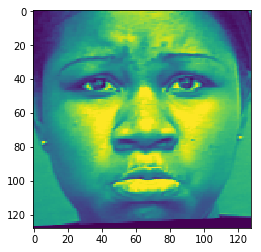

Predicted:  fear
Actual:  neutral


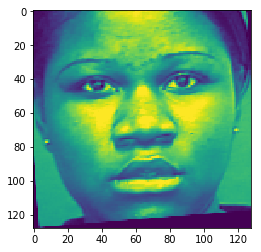

In [60]:
for i in range(length):
    print( 'Predicted: ', emotion_key[pred_incorrect[i]] )
    print( 'Actual: ', emotion_key[y_test_incorrect[i]] )
    image_side = X_test_incorrect[i].shape[1]
    image = np.reshape(X_test_incorrect[i], (image_side, image_side) )
    plt.imshow( image)
    plt.show()

# Test Less convolution layers

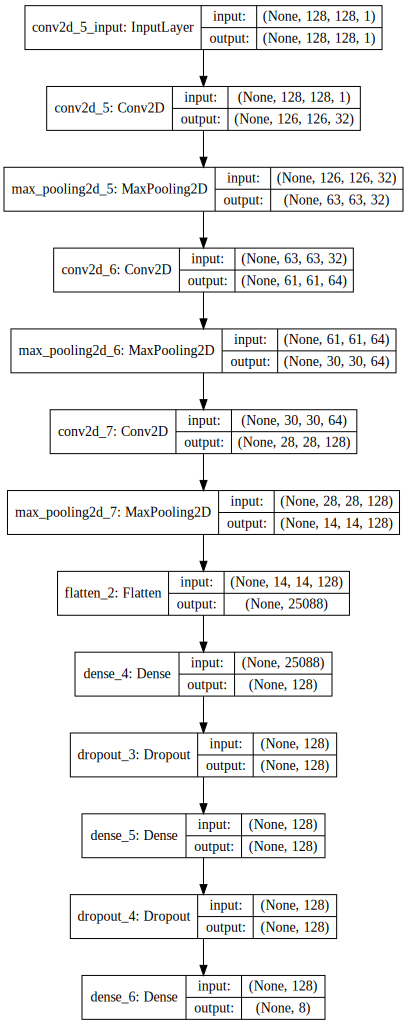

In [61]:
def construct_architecture_2(input_shape, num_classes):
    # instantiate model
    dnn_model = Sequential()
    # add convolution and pooling layers
    dnn_model.add( Conv2D(32, kernel_size=(3, 3), input_shape = input_shape, activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
    
    dnn_model.add( Conv2D(64, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
              
    dnn_model.add( Conv2D(128, kernel_size=(3, 3), activation = 'elu') )
    dnn_model.add( MaxPooling2D(pool_size=(2, 2)) )
    
    dnn_model.add( Flatten() )
    
    # add dense layers
    dnn_model.add( Dense(128, activation ='elu') )
    dnn_model.add( Dropout(0.4) )
    dnn_model.add( Dense(128, activation ='elu') )
    dnn_model.add( Dropout(0.4) )
    # define output layer
    dnn_model.add( Dense(num_classes, activation='softmax') )
    # compile model
    dnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return dnn_model

# Create model instance
classifier_02 = construct_architecture_2(input_shape, num_classes)

# Vizualize network achitecture
SVG(model_to_dot(classifier_02, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

In [62]:
classifier_02 = run_model(classifier_02, 'classifier_02')

Train on 1323 samples, validate on 147 samples
Epoch 1/20
1323/1323 [==============================] - 56s 42ms/step - loss: 13.3364 - acc: 0.1481 - val_loss: 13.9252 - val_acc: 0.1361
Epoch 2/20
1323/1323 [==============================] - 64s 48ms/step - loss: 13.3049 - acc: 0.1731 - val_loss: 13.9252 - val_acc: 0.1361
Epoch 3/20
1323/1323 [==============================] - 63s 47ms/step - loss: 13.1555 - acc: 0.1814 - val_loss: 14.5830 - val_acc: 0.0952
Epoch 4/20
1323/1323 [==============================] - 62s 47ms/step - loss: 13.7872 - acc: 0.1436 - val_loss: 14.5830 - val_acc: 0.0952
Epoch 5/20
1323/1323 [==============================] - 60s 45ms/step - loss: 13.7222 - acc: 0.1481 - val_loss: 14.5830 - val_acc: 0.0952
Epoch 6/20
1323/1323 [==============================] - 60s 45ms/step - loss: 13.8155 - acc: 0.1429 - val_loss: 14.5830 - val_acc: 0.0952
Epoch 7/20
1323/1323 [==============================] - 59s 44ms/step - loss: 13.6319 - acc: 0.1542 - val_loss: 14.5830 - val